## PART0: Environment Setup and Configure OpenAI API

In [1]:
# Import OpenAI Package
!pip install --upgrade openai
from openai import OpenAI

# Import os module to access environment variables
import os

# Load the API key from the .env file
from dotenv import load_dotenv
load_dotenv()

# Get the OpenAI API keys from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")

# Configure the OpenAI Client using key
openai_client = OpenAI(api_key = openai_api_key)
print("OpenAI client successfully configured.\n")

OpenAI client successfully configured.



## PART1: Read A Sample Image

In [2]:
# Define a helper function named "print_markdown" to display markdown
from IPython.display import display, Markdown  

def print_markdown(text):
    """Displays text as Markdown in Jupyter."""
    display(Markdown(text))

In [3]:
# Loading and displaying a sample image
# Use Pillow library (imported as PIL) for image processing

# Import Pillow for image handling
from PIL import Image  

Image 'images/food_image1.jpg' loaded successfully.
Format: JPEG
Size: (640, 480)
Mode: RGB


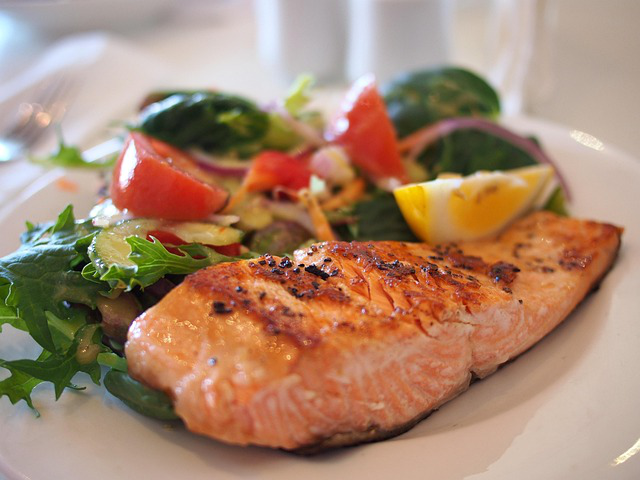

In [4]:
# Path to image file
image_filename = "images/food_image1.jpg"

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)
print(f"Image '{image_filename}' loaded successfully.")
print(f"Format: {img.format}")
print(f"Size: {img.size}")
print(f"Mode: {img.mode}")

# Use IPython.display to show the image directly in the notebook output
display(img)

# Keep the loaded image object in a variable for later use
image_to_analyze = img

## PART2: Perform Image Recognition Using OpenAI's Vision API

In [5]:
# Import io module to work with streams of data
import io  
# Used for encoding images for OpenAI's API
import base64  

In [6]:
# This function converts an image into base64 text format
# OpenAI requires images to be sent either as a URL or as a base64-encoded string. 
# I'll use base64 encoding for local files. The image is part of the `messages` list.

# This function works with two types of inputs: 
# (1) A file path: a string that tells the function where the image is stored on the computer.
# (2) An image object: a photo already loaded in memory using the PIL library (Python Imaging Library).

def encode_image_to_base64(image_path_or_pil):
    if isinstance(image_path_or_pil, str):  # If it's a file path
        # Check if the file exists
        if not os.path.exists(image_path_or_pil):
            raise FileNotFoundError(f"Image file not found at: {image_path_or_pil}")
        with open(image_path_or_pil, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
            
    elif isinstance(image_path_or_pil, Image.Image):  # If it's a PIL Image object
        buffer = io.BytesIO()
        image_format = image_path_or_pil.format or "JPEG"  # Default to JPEG if format unknown
        image_path_or_pil.save(buffer, format=image_format)
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError("Input must be a file path (str) or a PIL Image object.")


In [7]:
# Define a function that queries OpenAI's vision model with an image
def query_openai_vision(client, image, prompt, model = "gpt-4o", max_tokens = 200):
    """
    Function to query OpenAI's vision model with an image
    
    Args:
        client: The OpenAI client
        image: PIL Image object to analyze
        prompt: Text prompt to send with the image
        model: OpenAI model to use (default: gpt-4o)
        max_tokens: Maximum tokens in response (default: 100)
        
    Returns:
        The model's response text or an error message
    """

    # Encode the image to base64
    base64_image = encode_image_to_base64(image)
    
    try:
        # Construct the message payload
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                ],
            }
        ]

        # Make the API call
        response = client.chat.completions.create(
            model = model,
            messages = messages,
            max_tokens = max_tokens,
        )

        # Extract the response
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error calling API: {e}"

In [8]:
# Define the text prompt that will be sent with the image
food_recognition_prompt = """
Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Please identify the food item in this image.
Input: [The image I'm about to share]
Output: Provide the name of the food, a brief description of what you see, and if possible, mention its typical ingredients or nutritional profile.
"""

In [9]:
# Call the function and send the image
print("🤖 Querying OpenAI Vision...")
openai_description = query_openai_vision(
    openai_client, 
    image_to_analyze, 
    food_recognition_prompt
)
print_markdown(openai_description)


🤖 Querying OpenAI Vision...


The image shows a dish with a piece of grilled salmon and a salad. The salmon appears to be well-cooked with a slightly crispy exterior. The salad includes lettuce, tomato slices, some red onion, and a lemon wedge, which adds a fresh element to the dish.

**Typical Ingredients:**
- **Salmon:** High in protein and omega-3 fatty acids.
- **Salad:** Usually contains mixed greens, tomatoes, onion, and sometimes a vinaigrette dressing.

**Nutritional Profile:**
- **Salmon:** Rich in protein, healthy fats, and vitamins like B12 and D.
- **Salad:** Provides fiber, vitamins A and C, and other antioxidants.

This meal is generally nutritious, offering a good balance of proteins, healthy fats, and fresh vegetables.

## PART3: Get The Number Of Calories Using Vision API

In [24]:
# Define a structured prompt to ensure consistent model output
structured_nutrition_prompt = """
# Nutritional Analysis Task

## Context
You are a nutrition expert analyzing food images to provide accurate nutritional information.

## Instructions
Analyze the food item in the image and provide estimated nutritional information based on your knowledge.


## Input
- An image of a food item

## Output
Provide the following estimated nutritional information for a typical serving size or per 100g:
- food_name (string)
- serving_description (string, e.g., '1 slice', '100g', '1 cup')
- calories (float)
- fat_grams (float)
- protein_grams (float)
- confidence_level (string: 'High', 'Medium', or 'Low')

**IMPORTANT:** Respond ONLY with a single JSON object containing these fields. Enclosed in a Markdown JSON code block (```json ... ```). Do not include any other text, explanations, or apologies. The JSON keys must match exactly: "food_name", "serving_description", "calories", "fat_grams", "protein_grams", "confidence_level". If you cannot estimate a value, use `null`.

Example valid JSON response:
```json
{
  "food_name": "Banana",
  "serving_description": "1 medium banana (approx 118g)",
  "calories": 105.0,
  "fat_grams": 0.4,
  "protein_grams": 1.3,
  "confidence_level": "High"
}
```
"""

In [21]:
# Try the second food
image_filename = "images/food_image3.jpg"

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)

# Keep the loaded image object in a variable for later use
image_to_analyze = img

# Call OpenAI API with the image and the new structured prompt
openai_nutrition_result = query_openai_vision(client = openai_client,
                                              image = image_to_analyze,
                                              prompt = structured_nutrition_prompt,)

In [22]:
print_markdown(openai_nutrition_result)

```json
{
  "food_name": "Spaghetti with shrimp and parmesan",
  "serving_description": "1 serving (about 200g)",
  "calories": 390.0,
  "fat_grams": 12.0,
  "protein_grams": 25.0,
  "confidence_level": "Medium"
}
```